In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [70]:
data = pd.read_csv("creditcard.csv")

In [71]:
# Check for missing values
missing_values = data.isnull().value_counts()
print(missing_values)

Time   V1     V2     V3     V4     V5     V6     V7     V8     V9     V10    V11    V12    V13    V14    V15    V16    V17    V18    V19    V20    V21    V22    V23    V24    V25    V26    V27    V28    Amount  Class
False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False   False    284807
Name: count, dtype: int64


In [72]:
# Normalize Time and Amount
scaler = StandardScaler()
data[['Time', 'Amount']] = scaler.fit_transform(data[['Time', 'Amount']])

In [73]:
# Split data into features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    #here we spilted the data into test(20%) and training(80%)
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Display, to ensure that the data was slit correctly
X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((227845, 30),
 (56962, 30),
 Class
 0    227451
 1       394
 Name: count, dtype: int64,
 Class
 0    56864
 1       98
 Name: count, dtype: int64)

In [74]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [75]:
# Train a logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [76]:
# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]

In [77]:
# Evaluate the model using classification report and Precision-Recall AUC
report = classification_report(y_test, y_pred, digits=4)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)


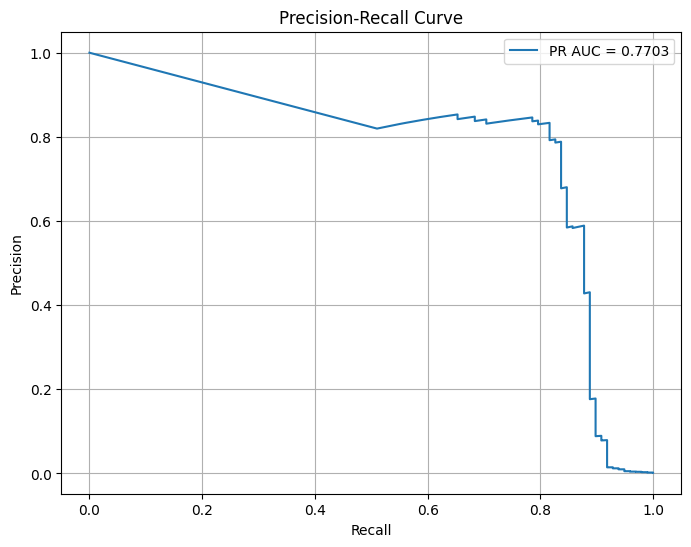

('              precision    recall  f1-score   support\n\n           0     0.9999    0.9744    0.9869     56864\n           1     0.0581    0.9184    0.1094        98\n\n    accuracy                         0.9743     56962\n   macro avg     0.5290    0.9464    0.5481     56962\nweighted avg     0.9982    0.9743    0.9854     56962\n',
 np.float64(0.7703412904668423))

In [78]:
# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

report, pr_auc

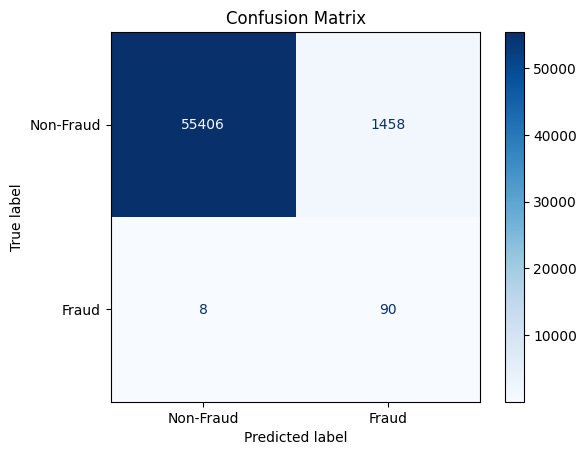

In [79]:
#Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Precision = 90/(90 + 1458) = 0.058
Only about 5.8% of the transactions flagged as fraud were actually fraud.

Recall = 90/(90 + 8) = 0.918
The model detected about 91.8% of the actual fraud cases.

Accuracy = (90 + 55406)/(55406 + 1458 + 90 + 8) = 0.974
About 97.4% of all transactions were classified correctly.

In [80]:
# Compute precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Find thresholds and metrics
threshold_metrics = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision[:-1],  # Exclude the last element (thresholds and precision lengths differ)
    'Recall': recall[:-1]
})

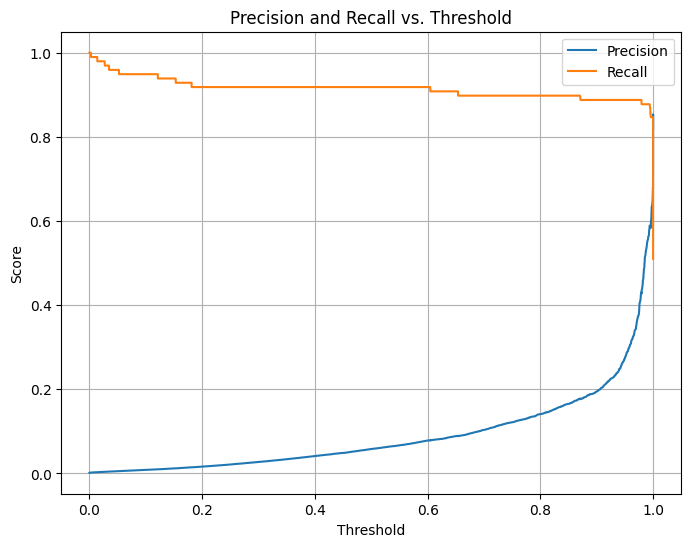

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")B
plt.legend()
plt.grid()
plt.show()


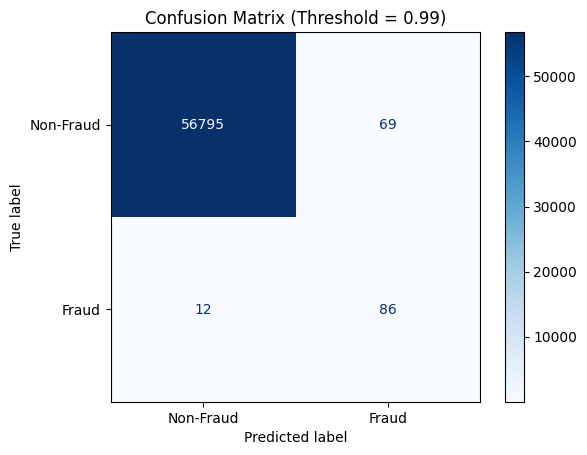

In [82]:
optimal_threshold = 0.99
y_pred_new = (y_pred_prob >= optimal_threshold).astype(int)

# Generate the confusion matrix with the new threshold
cm_new = confusion_matrix(y_test, y_pred_new)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=["Non-Fraud", "Fraud"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (Threshold = {optimal_threshold})")
plt.show()

Precision = 86/(86 + 69) = 0.555
Precision is about 55.5%.

Recall = 86/(86 + 12) = 0.878
Recall is about 87.8%.

Accuracy = (86 + 56795)/(56795 + 69 + 12 + 86) = 0.998
Accuracy is 99.8%, but this can be misleading in imbalanced datasets.